In [1]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [2]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Image shape:  (32, 32, 3)
Label:  0


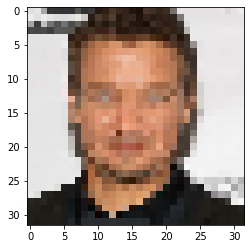

Image shape:  (32, 32, 3)
Label:  0


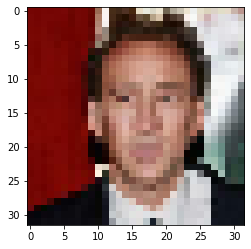

Image shape:  (32, 32, 3)
Label:  0


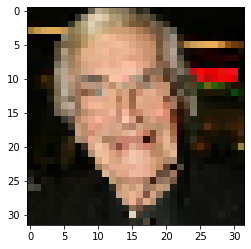

Image shape:  (32, 32, 3)
Label:  0


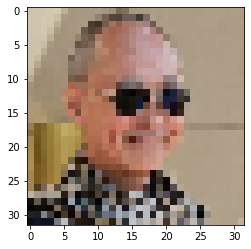

Image shape:  (32, 32, 3)
Label:  0


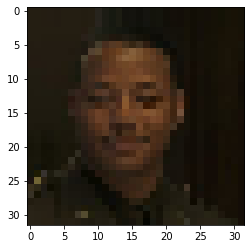

In [4]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [5]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [6]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [7]:
# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


In [8]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_train_transform.batch(batch_size)